In [18]:
# ========== Cell 1: imports & helper functions ==========
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def evaluate_series(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape_v = mape(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE(%)': mape_v}


In [19]:
# ========== Cell 2: load data & basic checks ==========
DATA_PATH = "D:\#Great Learning\MY\Project\Datasets\Steel Industry\Old Data.csv"

df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print("Shape:", df.shape)
print(df.columns.tolist())
display(df.head())


Shape: (28032, 11)
['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type']


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Weekday,Monday,Light_Load
1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
3,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load


In [20]:
# ========== Cell 3: prepare series & infer spacing ==========
target_col = 'Usage_kWh'

# set index
df_idx = df.set_index('date').copy()

# infer median spacing (minutes)
diffs = df_idx.index.to_series().diff().dropna().astype('timedelta64[s]') / 60.0
median_minutes = diffs.median()
print(f"Median spacing between records: {median_minutes:.2f} minutes")

if median_minutes <= 60:
    seq_len = 24  # hourly-like
    print("Treating as hourly-ish. Using seq_len = 24")
else:
    seq_len = 30  # daily-ish
    print("Treating as daily-ish. Using seq_len = 30")

# Train/test split (chronological)
n = len(df_idx)
split = int(n * 0.8)
train_ts = df_idx[target_col].iloc[:split].astype(float)
test_ts  = df_idx[target_col].iloc[split:].astype(float)
print("Train length:", len(train_ts), "Test length:", len(test_ts))


Median spacing between records: 15.00 minutes
Treating as hourly-ish. Using seq_len = 24
Train length: 22425 Test length: 5607


Fitting ARIMA (1, 1, 1)
ARIMA metrics: {'MAE': 28.08582991842044, 'RMSE': 32.940668822895496, 'MAPE(%)': 487.6339447534642}


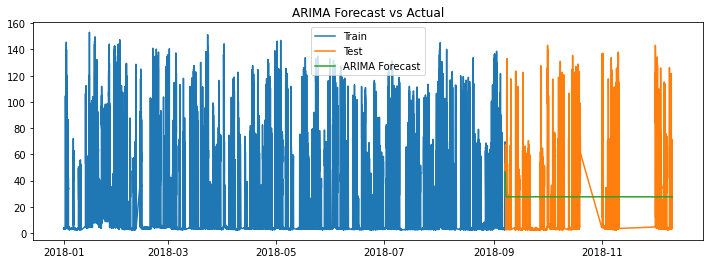

In [21]:
# ========== Cell 4: ARIMA baseline ==========
# Simple ARIMA(1,1,1) baseline - tune p,d,q later
from statsmodels.tsa.arima.model import ARIMA

arima_order = (1,1,1)
print("Fitting ARIMA", arima_order)
model_arima = ARIMA(train_ts, order=arima_order)
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=len(test_ts))

arima_metrics = evaluate_series(test_ts, arima_forecast)
print("ARIMA metrics:", arima_metrics)

plt.figure(figsize=(12,4))
plt.plot(train_ts.index, train_ts, label='Train')
plt.plot(test_ts.index, test_ts, label='Test')
plt.plot(test_ts.index, arima_forecast, label='ARIMA Forecast')
plt.legend(); plt.title("ARIMA Forecast vs Actual"); plt.show()


In [22]:
# ========== Cell 5: Prophet ==========
# If prophet isn't installed, run: pip install prophet
from prophet import Prophet

prophet_train = pd.DataFrame({'ds': train_ts.index, 'y': train_ts.values})

m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

try:
    m.fit(prophet_train)
except RuntimeError:
    print("Prophet failed — training only on last 10k records")
    prophet_train = prophet_train.iloc[-10000:]
    m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(test_ts))
forecast = m.predict(future)

prophet_pred = forecast.set_index('ds')['yhat'].loc[test_ts.index].values

prophet_metrics = evaluate_series(test_ts.values, prophet_pred)
print("Prophet metrics:", prophet_metrics)



23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - ERROR - Chain [1] error: code '3221225785' 
Optimization terminated abnormally. Falling back to Newton.
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - ERROR - Chain [1] error: code '3221225785' 


Prophet failed — training only on last 10k records


Exception: Prophet object can only be fit once. Instantiate a new object.

In [23]:
# ========== Cell 6: prepare data for LSTM/GRU ==========
from sklearn.preprocessing import MinMaxScaler

values = df_idx[[target_col]].astype(float).values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

train_scaled = scaled[:split]
test_scaled  = scaled[split:]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# Training sequences (only from train)
X_train_seq, y_train_seq = create_sequences(train_scaled, seq_len)

# For test, create sequences that use last seq_len points from train followed by test
combined = np.vstack([train_scaled[-seq_len:], test_scaled])
X_test_seq, y_test_seq = create_sequences(combined, seq_len)

# reshape for keras
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

print("X_train_seq shape:", X_train_seq.shape, "X_test_seq shape:", X_test_seq.shape)
        

X_train_seq shape: (22401, 24, 1) X_test_seq shape: (5607, 24, 1)


Epoch 1/50
315/315 [==============================] - 4s 8ms/step - loss: 0.0175 - val_loss: 0.0095
Epoch 2/50
315/315 [==============================] - 2s 8ms/step - loss: 0.0109 - val_loss: 0.0075
Epoch 3/50
315/315 [==============================] - 2s 8ms/step - loss: 0.0099 - val_loss: 0.0072
Epoch 4/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 5/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0093 - val_loss: 0.0066
Epoch 6/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 7/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 8/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 9/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 10/50
315/315 [==============================] - 2s 7ms/step - loss: 0.0078 - val_loss: 0.0056

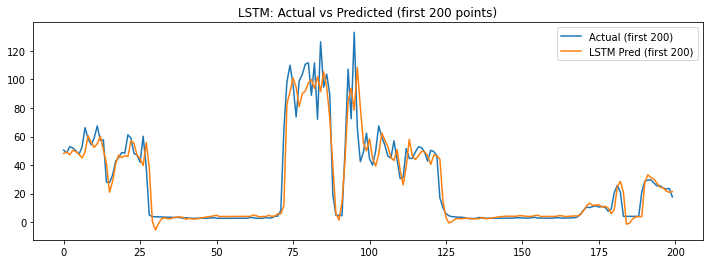

In [24]:
# ========== Cell 7: LSTM training ==========
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, validation_split=0.1, callbacks=[es], verbose=1)

# predict on X_test_seq
lstm_pred_scaled = model_lstm.predict(X_test_seq).flatten()
lstm_pred = scaler.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()
y_test_true = scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

lstm_metrics = evaluate_series(y_test_true, lstm_pred)
print("LSTM metrics:", lstm_metrics)

plt.figure(figsize=(12,4))
plt.plot(y_test_true[:200], label='Actual (first 200)')
plt.plot(lstm_pred[:200], label='LSTM Pred (first 200)')
plt.legend(); plt.title("LSTM: Actual vs Predicted (first 200 points)"); plt.show()


Epoch 1/50
315/315 [==============================] - 3s 6ms/step - loss: 0.0171 - val_loss: 0.0082
Epoch 2/50
315/315 [==============================] - 2s 5ms/step - loss: 0.0103 - val_loss: 0.0073
Epoch 3/50
315/315 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 4/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 5/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 6/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 7/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 8/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 9/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0084 - val_loss: 0.0061
Epoch 10/50
315/315 [==============================] - 2s 6ms/step - loss: 0.0082 - val_loss: 0.0060

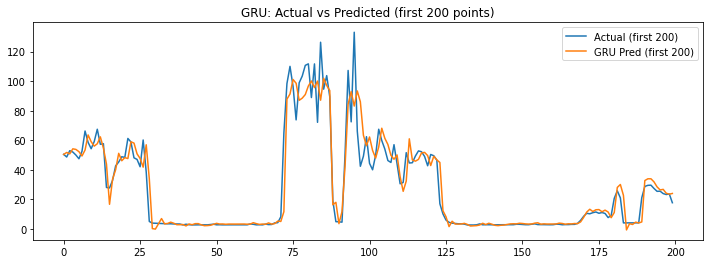

In [25]:
# ========== Cell 8: GRU training ==========
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model_gru = Sequential([
    GRU(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')

es2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history2 = model_gru.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, validation_split=0.1, callbacks=[es2], verbose=1)

gru_pred_scaled = model_gru.predict(X_test_seq).flatten()
gru_pred = scaler.inverse_transform(gru_pred_scaled.reshape(-1,1)).flatten()

gru_metrics = evaluate_series(y_test_true, gru_pred)
print("GRU metrics:", gru_metrics)

plt.figure(figsize=(12,4))
plt.plot(y_test_true[:200], label='Actual (first 200)')
plt.plot(gru_pred[:200], label='GRU Pred (first 200)')
plt.legend(); plt.title("GRU: Actual vs Predicted (first 200 points)"); plt.show()


In [26]:
# ========== Cell 9: Summary table ==========
rows = []
try:
    rows.append(['ARIMA', arima_metrics['MAE'], arima_metrics['RMSE'], arima_metrics['MAPE(%)']])
except:
    pass
try:
    rows.append(['Prophet', prophet_metrics['MAE'], prophet_metrics['RMSE'], prophet_metrics['MAPE(%)']])
except:
    pass
try:
    rows.append(['LSTM', lstm_metrics['MAE'], lstm_metrics['RMSE'], lstm_metrics['MAPE(%)']])
except:
    pass
try:
    rows.append(['GRU', gru_metrics['MAE'], gru_metrics['RMSE'], gru_metrics['MAPE(%)']])
except:
    pass

summary_df = pd.DataFrame(rows, columns=['Model','MAE','RMSE','MAPE(%)'])
display(summary_df)


,Model,MAE,RMSE,MAPE(%)
0,ARIMA,28.085830,32.940669,487.633945
1,LSTM,5.801919,11.258693,42.102998
2,GRU,5.161513,10.742892,29.059345
